In [1]:
!pip install tensorflow
!pip install tensorflow-federated==0.39

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.9/912.9 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 75.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7

In [2]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

%load_ext tensorboard

2023-05-11 19:29:12.551344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 19:29:13.111233: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-11 19:29:14.276675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-11 19:29:14.276827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [4]:
! pip install kaggle -q

In [8]:
#Download and unzip Kaggle dataset

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download yuweisunut/sidd-segmented-intrusion-detection-dataset
!unzip -q sidd-segmented-intrusion-detection-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|███████████████████████████████████████▉| 699M/700M [00:08<00:00, 94.9MB/s]
100%|████████████████████████████████████████| 700M/700M [00:08<00:00, 85.3MB/s]


In [3]:
NUM_CLIENTS = 15
NUM_EPOCHS = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER = 400
PREFETCH_BUFFER = tf.data.AUTOTUNE

In [5]:
directory = 'SIDD'
client_id = 0
imgs = {}
uid = 0
label_counts = {0: 0, 1: 0}

for client in os.listdir(directory):
    curr_path = f'{directory}/{client}/pcap'

    for subdir in os.listdir(curr_path):
        curr_path = f'{directory}/{client}/pcap/{subdir}/dataset'
        curr_type = subdir[-1:]
        if curr_type == str(1):
            for dayscen in os.listdir(curr_path):
                curr_path = f'{directory}/{client}/pcap/{subdir}/dataset/{dayscen}'
                for i, img in enumerate(os.listdir(curr_path)):
                    if i == 45:
                       break
                    if dayscen == 'benign':
                        label = 0
                        imgs[uid] = {'id': uid, 'client_id': client_id, 'label': str(label), 'fn': img, 'path': curr_path + '/' + img}
                        uid +=1
                        label_counts[label] += 1
                    elif dayscen == 'malicious':
                        label = 1
                        imgs[uid] = {'id': uid, 'client_id': client_id, 'label': str(label), 'fn': img, 'path': curr_path + '/' + img}
                        uid += 1
                        label_counts[label] += 1
    client_id += 1

total = label_counts[1] + label_counts[0]
neg = label_counts[0]
pos = label_counts[1]

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

img_df = pd.DataFrame.from_dict(imgs,orient='index')
img_df['label'] = img_df['label'].astype(int)
#img_df.loc[img_df.index[(img_df['label']==3)],'label'] = 2

file_paths = img_df.path
file_labels = img_df["label"].values.reshape(-1, 1)
client_ids = img_df["client_id"]  
    
X = file_paths
y = file_labels
client_ds = tf.data.Dataset.from_tensor_slices((X, y, client_ids))
test_size = 0.2
train_size = 1 - test_size
ds_length = tf.data.experimental.cardinality(client_ds).numpy()
num_test_samples = int(test_size * ds_length)

#train_ds = client_ds
train_ds = client_ds.take(train_size * ds_length)
test_ds = client_ds.skip(train_size * ds_length)


print(train_ds.cardinality().numpy())

Weight for class 0: 0.57
Weight for class 1: 4.08
42395


In [5]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=1)
    image = tf.cast(image_decoded, tf.float32)
    image /= 255.0
    label = tf.reshape(label, [1])
    return image, label

In [6]:
def preprocess(dataset):

  return dataset.map(load_image).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=12).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)

def make_federated_data(client_data, client_ids):
    return [
      preprocess(create_tf_dataset_for_client(client_data, x))
      for x in client_ids
    ]


def preprocess_test(dataset):

  return dataset.map(load_image).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

def make_federated_testdata(client_data, client_ids):
    return [
      preprocess_test(create_tf_dataset_for_client(client_data, x))
      for x in client_ids
    ]

In [7]:
def load_image(filename, label):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=1)
        image = tf.cast(image_decoded, tf.float32)
        image /= 255.0
        label = tf.reshape(label, [1])
        return image, label

In [8]:
def create_tf_dataset_for_client(dataset, id_value):
    # Filter elements with the specified id_value
    
    filtered_dataset = dataset.filter(lambda x, y, client_id: tf.equal(client_id, id_value))

    # Remove the id from the filtered dataset
    filtered_dataset = filtered_dataset.map(lambda x, y, client_id: (x, y))
        
    #Load image from path and convert to float32
    def load_image(filename, label):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=1)
        image = tf.cast(image_decoded, tf.float32)
        image /= 255.0
        label = tf.reshape(label, [1])
        return image, label

    #filtered_dataset = filtered_dataset.map(load_image)
    
    #print(type(filtered_dataset))


    return filtered_dataset


In [9]:
clients = img_df["client_id"].unique()
#print(type(client_ds))
federated_train_data = make_federated_data(train_ds, clients)
federated_test_data = make_federated_testdata(test_ds, clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 15
First dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [10]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    
    height = 48
    width = 48
    channels = 1

    input_shape = (height, width, channels)

    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary crossentropy loss and Adam optimizer
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return tff.learning.from_keras_model(
          model,
          input_spec=federated_train_data[0].element_spec,
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [11]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

eval_process = tff.learning.build_federated_evaluation(model_fn)

In [12]:
train_state = training_process.initialize()
eval_results_df = pd.DataFrame()
train_results_df = pd.DataFrame()

In [15]:
log_dir = 'logs/fit_federated/'
summary_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

NUM_ROUNDS = 70
with summary_writer.as_default():

    for round_num in range(NUM_ROUNDS):
        
      #Training of actual model  
      result = training_process.next(train_state, federated_train_data)
      train_state = result.state
      train_metrics = result.metrics
        
      accuracy = result.metrics['client_work']['train']['binary_accuracy']
      loss = result.metrics['client_work']['train']['loss']
      precision = result.metrics['client_work']['train']['precision']
      recall = result.metrics['client_work']['train']['recall']
    
      f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
      print(f1_score)  
      train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)  
      print('round {:2d}, metrics={}'.format(round_num, train_metrics))
      
      #Evaluate model
      model_weights = training_process.get_model_weights(train_state)
      test_metrics = eval_process(model_weights, federated_test_data)['eval']
      print(test_metrics)
      
      val_pre = test_metrics['precision']
      val_rec = test_metrics['recall']
      val_f1_score = 2 * val_pre * val_rec / (val_pre + val_rec + tf.keras.backend.epsilon())
        
      eval_results_df = eval_results_df.append({'Round': round_num+1,
                                      **test_metrics, 'F1 Score': val_f1_score}, ignore_index=True)  


callbacks = [TensorBoard(log_dir=log_dir)]

0.04072195132693828
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.630485), ('recall', 0.021040462), ('binary_accuracy', 0.8988717), ('true_positives', 273.0), ('true_negatives', 114050.0), ('false_negatives', 12702.0), ('false_positives', 160.0), ('loss', 0.28856045), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1913476), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.05114937817807028
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.62454873), ('recall', 0.026666667), ('binary_accuracy', 0.8990683), ('true_positives', 346.0), ('true_negatives', 114002.0), ('false_negatives', 12629.0), ('false_positives', 208.0), ('loss', 0.28943163), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1956226), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.05522826532331753
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.6198347), ('recall', 0.028901733), ('binary_accuracy', 0.8991233), ('true_positives', 375.0), ('true_negatives', 113980.0), ('false_negatives', 12600.0), ('false_positives', 230.0), ('loss', 0.2893509), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.20476), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.07015758904239103
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.60831237), ('recall', 0.037225433), ('binary_accuracy', 0.8993356), ('true_positives', 483.0), ('true_negatives', 113899.0), ('false_negatives', 12492.0), ('false_positives', 311.0), ('loss', 0.28992283), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2103574), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.085051717810514
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5730769), ('recall', 0.04593449), ('binary_accuracy', 0.8991784), ('true_positives', 596.0), ('true_negatives', 113766.0), ('false_negatives', 12379.0), ('false_positives', 444.0), ('loss', 0.28919983), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2169727), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09259258069944798
round  5, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5583973), ('recall', 0.050481696), ('binary_accuracy', 0.8990604), ('true_positives', 655.0), ('true_negatives', 113692.0), ('false_negatives', 12320.0), ('false_positives', 518.0), ('loss', 0.28992313), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2243735), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09885930049552134
round  6, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.57212716), ('recall', 0.054104045), ('binary_accuracy', 0.8993749), ('true_positives', 702.0), ('true_negatives', 113685.0), ('false_negatives', 12273.0), ('false_positives', 525.0), ('loss', 0.29003564), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2285), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.10977723764769001
round  7, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.55083567), ('recall', 0.060963392), ('binary_accuracy', 0.8991312), ('true_positives', 791.0), ('true_negatives', 113565.0), ('false_negatives', 12184.0), ('false_positives', 645.0), ('loss', 0.28970444), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2287434), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1241020565003931
round  8, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.55237514), ('recall', 0.069903664), ('binary_accuracy', 0.8993356), ('true_positives', 907.0), ('true_negatives', 113475.0), ('false_negatives', 12068.0), ('false_positives', 735.0), ('loss', 0.28993103), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2289883), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.12408507845251952
round  9, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.55170316), ('recall', 0.069903664), ('binary_accuracy', 0.8993199), ('true_positives', 907.0), ('true_negatives', 113473.0), ('false_negatives', 12068.0), ('false_positives', 737.0), ('loss', 0.28797254), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2336777), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.13197691977097498
round 10, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5497175), ('recall', 0.07499037), ('binary_accuracy', 0.89936703), ('true_positives', 973.0), ('true_negatives', 113413.0), ('false_negatives', 12002.0), ('false_positives', 797.0), ('loss', 0.28807703), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2411666), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.13379187851109348
round 11, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.53505933), ('recall', 0.07645472), ('binary_accuracy', 0.8990054), ('true_positives', 992.0), ('true_negatives', 113348.0), ('false_negatives', 11983.0), ('false_positives', 862.0), ('loss', 0.2893078), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2431631), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.13463095140312417
round 12, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.54695225), ('recall', 0.076763004), ('binary_accuracy', 0.89932775), ('true_positives', 996.0), ('true_negatives', 113385.0), ('false_negatives', 11979.0), ('false_positives', 825.0), ('loss', 0.28879443), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2415676), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.14210207094933253
round 13, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5385395), ('recall', 0.08184971), ('binary_accuracy', 0.8991784), ('true_positives', 1062.0), ('true_negatives', 113300.0), ('false_negatives', 11913.0), ('false_positives', 910.0), ('loss', 0.2876684), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2501998), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.14541339850110643
round 14, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5310981), ('recall', 0.084238924), ('binary_accuracy', 0.8989897), ('true_positives', 1093.0), ('true_negatives', 113245.0), ('false_negatives', 11882.0), ('false_positives', 965.0), ('loss', 0.28840744), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2497252), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.14677801901290452
round 15, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.52489334), ('recall', 0.08531792), ('binary_accuracy', 0.89880884), ('true_positives', 1107.0), ('true_negatives', 113208.0), ('false_negatives', 11868.0), ('false_positives', 1002.0), ('loss', 0.28716886), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2566494), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.15155897832081217
round 16, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.51728785), ('recall', 0.088786125), ('binary_accuracy', 0.89858866), ('true_positives', 1152.0), ('true_negatives', 113135.0), ('false_negatives', 11823.0), ('false_positives', 1075.0), ('loss', 0.28875357), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2499504), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1536241150811538
round 17, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.515859), ('recall', 0.090250485), ('binary_accuracy', 0.8985494), ('true_positives', 1171.0), ('true_negatives', 113111.0), ('false_negatives', 11804.0), ('false_positives', 1099.0), ('loss', 0.2858085), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2562778), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.15628062856451094
round 18, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.51553065), ('recall', 0.092100196), ('binary_accuracy', 0.8985494), ('true_positives', 1195.0), ('true_negatives', 113087.0), ('false_negatives', 11780.0), ('false_positives', 1123.0), ('loss', 0.28612998), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2588342), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.16077585647130788
round 19, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5171692), ('recall', 0.095183045), ('binary_accuracy', 0.898628), ('true_positives', 1235.0), ('true_negatives', 113057.0), ('false_negatives', 11740.0), ('false_positives', 1153.0), ('loss', 0.28568146), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2556566), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.16282678632323916
round 20, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5078724), ('recall', 0.09695569), ('binary_accuracy', 0.8982899), ('true_positives', 1258.0), ('true_negatives', 112991.0), ('false_negatives', 11717.0), ('false_positives', 1219.0), ('loss', 0.28493348), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2596295), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.16252264410921685
round 21, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5083029), ('recall', 0.09672447), ('binary_accuracy', 0.8983056), ('true_positives', 1255.0), ('true_negatives', 112996.0), ('false_negatives', 11720.0), ('false_positives', 1214.0), ('loss', 0.28422853), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.258141), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.16472565156528132
round 22, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.51309955), ('recall', 0.098111756), ('binary_accuracy', 0.8984943), ('true_positives', 1273.0), ('true_negatives', 113002.0), ('false_negatives', 11702.0), ('false_positives', 1208.0), ('loss', 0.28428966), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2631873), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1685089602226822
round 23, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.50715667), ('recall', 0.10104046), ('binary_accuracy', 0.8982742), ('true_positives', 1311.0), ('true_negatives', 112936.0), ('false_negatives', 11664.0), ('false_positives', 1274.0), ('loss', 0.28300738), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2644261), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.17074263340968876
round 24, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5107527), ('recall', 0.10250482), ('binary_accuracy', 0.89842355), ('true_positives', 1330.0), ('true_negatives', 112936.0), ('false_negatives', 11645.0), ('false_positives', 1274.0), ('loss', 0.28267068), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.267263), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.17333074420359745
round 25, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5022173), ('recall', 0.10473988), ('binary_accuracy', 0.8980776), ('true_positives', 1359.0), ('true_negatives', 112863.0), ('false_negatives', 11616.0), ('false_positives', 1347.0), ('loss', 0.28269002), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2655351), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1727122074906167
round 26, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49543628), ('recall', 0.104585744), ('binary_accuracy', 0.8977867), ('true_positives', 1357.0), ('true_negatives', 112828.0), ('false_negatives', 11618.0), ('false_positives', 1382.0), ('loss', 0.2821496), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2692287), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.17620133701284207
round 27, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.50272036), ('recall', 0.10682081), ('binary_accuracy', 0.8981012), ('true_positives', 1386.0), ('true_negatives', 112839.0), ('false_negatives', 11589.0), ('false_positives', 1371.0), ('loss', 0.28155738), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2711864), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1784720178617154
round 28, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49735636), ('recall', 0.108747594), ('binary_accuracy', 0.8978653), ('true_positives', 1411.0), ('true_negatives', 112784.0), ('false_negatives', 11564.0), ('false_positives', 1426.0), ('loss', 0.28117388), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2681779), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18138240671536912
round 29, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49913225), ('recall', 0.11082852), ('binary_accuracy', 0.8979439), ('true_positives', 1438.0), ('true_negatives', 112767.0), ('false_negatives', 11537.0), ('false_positives', 1443.0), ('loss', 0.28029314), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2637118), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.180434061703786
round 30, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.4910959), ('recall', 0.11052023), ('binary_accuracy', 0.8975744), ('true_positives', 1434.0), ('true_negatives', 112724.0), ('false_negatives', 11541.0), ('false_positives', 1486.0), ('loss', 0.27987504), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2662735), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18147372742561904
round 31, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5020964), ('recall', 0.11075144), ('binary_accuracy', 0.8980776), ('true_positives', 1437.0), ('true_negatives', 112785.0), ('false_negatives', 11538.0), ('false_positives', 1425.0), ('loss', 0.27995583), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2684673), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18067357083602695
round 32, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49312714), ('recall', 0.110597305), ('binary_accuracy', 0.8976688), ('true_positives', 1435.0), ('true_negatives', 112735.0), ('false_negatives', 11540.0), ('false_positives', 1475.0), ('loss', 0.28047135), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2592096), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18380411029920923
round 33, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49543148), ('recall', 0.11283237), ('binary_accuracy', 0.89777094), ('true_positives', 1464.0), ('true_negatives', 112719.0), ('false_negatives', 11511.0), ('false_positives', 1491.0), ('loss', 0.27787998), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2601241), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1887356973467992
round 34, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.4947678), ('recall', 0.116608866), ('binary_accuracy', 0.89773166), ('true_positives', 1513.0), ('true_negatives', 112665.0), ('false_negatives', 11462.0), ('false_positives', 1545.0), ('loss', 0.2769471), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2546678), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18237804885675385
round 35, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49404153), ('recall', 0.11183044), ('binary_accuracy', 0.89770806), ('true_positives', 1451.0), ('true_negatives', 112724.0), ('false_negatives', 11524.0), ('false_positives', 1486.0), ('loss', 0.2765201), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.258088), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18173834114139248
round 36, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.4877146), ('recall', 0.1116763), ('binary_accuracy', 0.89740926), ('true_positives', 1449.0), ('true_negatives', 112688.0), ('false_negatives', 11526.0), ('false_positives', 1522.0), ('loss', 0.27644125), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2593249), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18723879410379324
round 37, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49084368), ('recall', 0.11568401), ('binary_accuracy', 0.89754295), ('true_positives', 1501.0), ('true_negatives', 112653.0), ('false_negatives', 11474.0), ('false_positives', 1557.0), ('loss', 0.2764847), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.26327), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18459991640459736
round 38, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49512276), ('recall', 0.11344894), ('binary_accuracy', 0.89775527), ('true_positives', 1472.0), ('true_negatives', 112709.0), ('false_negatives', 11503.0), ('false_positives', 1501.0), ('loss', 0.27725643), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2638906), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.19249671156286272
round 39, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49935442), ('recall', 0.11922929), ('binary_accuracy', 0.8979518), ('true_positives', 1547.0), ('true_negatives', 112659.0), ('false_negatives', 11428.0), ('false_positives', 1551.0), ('loss', 0.27666867), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2556971), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.19174678284188393
round 40, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.49203822), ('recall', 0.11907514), ('binary_accuracy', 0.8975901), ('true_positives', 1545.0), ('true_negatives', 112615.0), ('false_negatives', 11430.0), ('false_positives', 1595.0), ('loss', 0.27459145), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2578394), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1948219321602973
round 41, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.48204505), ('recall', 0.12208092), ('binary_accuracy', 0.89705545), ('true_positives', 1584.0), ('true_negatives', 112508.0), ('false_negatives', 11391.0), ('false_positives', 1702.0), ('loss', 0.27552587), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2514865), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.19789546885157755
round 42, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.4908425), ('recall', 0.12393063), ('binary_accuracy', 0.8975115), ('true_positives', 1608.0), ('true_negatives', 112542.0), ('false_negatives', 11367.0), ('false_positives', 1668.0), ('loss', 0.2743821), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2584555), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.19695566004610637
round 43, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.4913899), ('recall', 0.12315992), ('binary_accuracy', 0.89754295), ('true_positives', 1598.0), ('true_negatives', 112556.0), ('false_negatives', 11377.0), ('false_positives', 1654.0), ('loss', 0.275627), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2552744), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.20124858748413557
round 44, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.48884925), ('recall', 0.1267052), ('binary_accuracy', 0.8973936), ('true_positives', 1644.0), ('true_negatives', 112491.0), ('false_negatives', 11331.0), ('false_positives', 1719.0), ('loss', 0.27440414), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.254602), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.20583769705754498
round 45, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.48401827), ('recall', 0.13071291), ('binary_accuracy', 0.89710265), ('true_positives', 1696.0), ('true_negatives', 112402.0), ('false_negatives', 11279.0), ('false_positives', 1808.0), ('loss', 0.2742457), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2580844), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.21119435593291933
round 46, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.48949286), ('recall', 0.13464354), ('binary_accuracy', 0.8973936), ('true_positives', 1747.0), ('true_negatives', 112388.0), ('false_negatives', 11228.0), ('false_positives', 1822.0), ('loss', 0.2747154), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2541275), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.21634526466157797
round 47, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.47987288), ('recall', 0.13965318), ('binary_accuracy', 0.8967881), ('true_positives', 1812.0), ('true_negatives', 112246.0), ('false_negatives', 11163.0), ('false_positives', 1964.0), ('loss', 0.27328354), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2528732), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.20097702118004127
round 48, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.50844806), ('recall', 0.12524085), ('binary_accuracy', 0.8984078), ('true_positives', 1625.0), ('true_negatives', 112639.0), ('false_negatives', 11350.0), ('false_positives', 1571.0), ('loss', 0.27325428), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.252601), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.19246911004022826
round 49, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.51440054), ('recall', 0.1183815), ('binary_accuracy', 0.8986594), ('true_positives', 1536.0), ('true_negatives', 112760.0), ('false_negatives', 11439.0), ('false_positives', 1450.0), ('loss', 0.27260274), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2420582), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.18354467652162887
round 50, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5301915), ('recall', 0.11098266), ('binary_accuracy', 0.89927274), ('true_positives', 1440.0), ('true_negatives', 112934.0), ('false_negatives', 11535.0), ('false_positives', 1276.0), ('loss', 0.2702414), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2356439), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1773076544708617
round 51, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.52685714), ('recall', 0.10658959), ('binary_accuracy', 0.8990919), ('true_positives', 1383.0), ('true_negatives', 112968.0), ('false_negatives', 11592.0), ('false_positives', 1242.0), ('loss', 0.26853296), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2314537), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.17410970991349456
round 52, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.53923136), ('recall', 0.10381503), ('binary_accuracy', 0.89952433), ('true_positives', 1347.0), ('true_negatives', 113059.0), ('false_negatives', 11628.0), ('false_positives', 1151.0), ('loss', 0.26757926), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2162696), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.16847294462883178
round 53, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5332785), ('recall', 0.100038536), ('binary_accuracy', 0.899257), ('true_positives', 1298.0), ('true_negatives', 113074.0), ('false_negatives', 11677.0), ('false_positives', 1136.0), ('loss', 0.26524746), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.2052929), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.15011943338323563
round 54, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.54037267), ('recall', 0.08716763), ('binary_accuracy', 0.899312), ('true_positives', 1131.0), ('true_negatives', 113248.0), ('false_negatives', 11844.0), ('false_positives', 962.0), ('loss', 0.26292303), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.202236), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.12551495234422902
round 55, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.57520455), ('recall', 0.07044316), ('binary_accuracy', 0.8998624), ('true_positives', 914.0), ('true_negatives', 113535.0), ('false_negatives', 12061.0), ('false_positives', 675.0), ('loss', 0.26328713), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1836327), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.1039179740645915
round 56, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.58405685), ('recall', 0.057032757), ('binary_accuracy', 0.89965796), ('true_positives', 740.0), ('true_negatives', 113683.0), ('false_negatives', 12235.0), ('false_positives', 527.0), ('loss', 0.25917888), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1669003), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08409741467439795
round 57, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5959391), ('recall', 0.04524085), ('binary_accuracy', 0.89946926), ('true_positives', 587.0), ('true_negatives', 113812.0), ('false_negatives', 12388.0), ('false_positives', 398.0), ('loss', 0.25670967), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1641717), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08047217044760446
round 58, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.60893244), ('recall', 0.043082852), ('binary_accuracy', 0.89955574), ('true_positives', 559.0), ('true_negatives', 113851.0), ('false_negatives', 12416.0), ('false_positives', 359.0), ('loss', 0.25504106), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1489753), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.07762226839712123
round 59, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.6065389), ('recall', 0.041464355), ('binary_accuracy', 0.89946926), ('true_positives', 538.0), ('true_negatives', 113861.0), ('false_negatives', 12437.0), ('false_positives', 349.0), ('loss', 0.252911), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1457269), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08009218233247731
round 60, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.6116612), ('recall', 0.042851638), ('binary_accuracy', 0.89957935), ('true_positives', 556.0), ('true_negatives', 113857.0), ('false_negatives', 12419.0), ('false_positives', 353.0), ('loss', 0.2513969), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1420919), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.07951024916571212
round 61, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.60659343), ('recall', 0.04254335), ('binary_accuracy', 0.8995086), ('true_positives', 552.0), ('true_negatives', 113852.0), ('false_negatives', 12423.0), ('false_positives', 358.0), ('loss', 0.2509027), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1366118), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08141540752627173
round 62, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.6092573), ('recall', 0.043622352), ('binary_accuracy', 0.89957935), ('true_positives', 566.0), ('true_negatives', 113847.0), ('false_negatives', 12409.0), ('false_positives', 363.0), ('loss', 0.25027052), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1368918), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08519471637589102
round 63, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.59919435), ('recall', 0.04585742), ('binary_accuracy', 0.8995322), ('true_positives', 595.0), ('true_negatives', 113812.0), ('false_negatives', 12380.0), ('false_positives', 398.0), ('loss', 0.24964921), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1368282), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08605998610354394
round 64, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.60584676), ('recall', 0.046319846), ('binary_accuracy', 0.89963436), ('true_positives', 601.0), ('true_negatives', 113819.0), ('false_negatives', 12374.0), ('false_positives', 391.0), ('loss', 0.24983917), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1305538), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.08928825117671006
round 65, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5978988), ('recall', 0.04824663), ('binary_accuracy', 0.8995951), ('true_positives', 626.0), ('true_negatives', 113789.0), ('false_negatives', 12349.0), ('false_positives', 421.0), ('loss', 0.24817963), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1310011), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09338354175568067
round 66, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.59945256), ('recall', 0.050635837), ('binary_accuracy', 0.8996973), ('true_positives', 657.0), ('true_negatives', 113771.0), ('false_negatives', 12318.0), ('false_positives', 439.0), ('loss', 0.24752092), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1295727), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09123904351109115
round 67, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5957249), ('recall', 0.0494027), ('binary_accuracy', 0.89960295), ('true_positives', 641.0), ('true_negatives', 113775.0), ('false_negatives', 12334.0), ('false_positives', 435.0), ('loss', 0.24713098), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1270853), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09493445192575412
round 68, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5877193), ('recall', 0.051637765), ('binary_accuracy', 0.89955574), ('true_positives', 670.0), ('true_negatives', 113740.0), ('false_negatives', 12305.0), ('false_positives', 470.0), ('loss', 0.24686658), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1214267), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


0.09864519926907164
round 69, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('precision', 0.5839599), ('recall', 0.05387283), ('binary_accuracy', 0.8995636), ('true_positives', 699.0), ('true_negatives', 113712.0), ('false_negatives', 12276.0), ('false_positives', 498.0), ('loss', 0.24597678), ('num_examples', 127185), ('num_batches', 504)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


/tmp/ipykernel_32/32353642.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append({'Round': round_num+1, 'BinaryAccuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)


OrderedDict([('precision', 0.0), ('recall', 0.0), ('binary_accuracy', 0.79469764), ('true_positives', 0.0), ('true_negatives', 8423.0), ('false_negatives', 2176.0), ('false_positives', 0.0), ('loss', 1.1220765), ('num_examples', 10599), ('num_batches', 43)])


/tmp/ipykernel_32/32353642.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,


Index(['Round', 'Precision', 'Recall', 'binary_accuracy', 'true_positives',
       'true_negatives', 'false_negatives', 'false_positives', 'Loss',
       'num_examples', 'num_batches', 'F1 Score'],
      dtype='object')


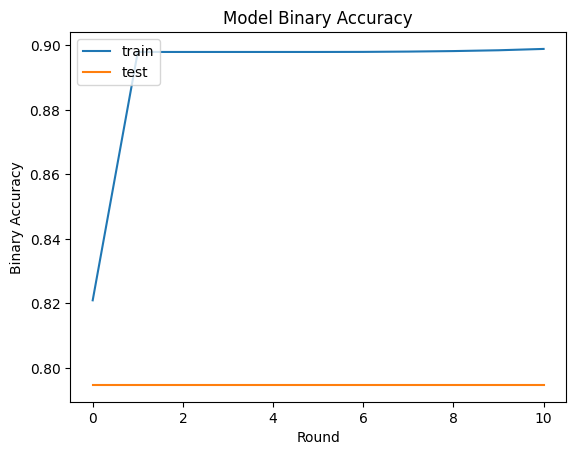

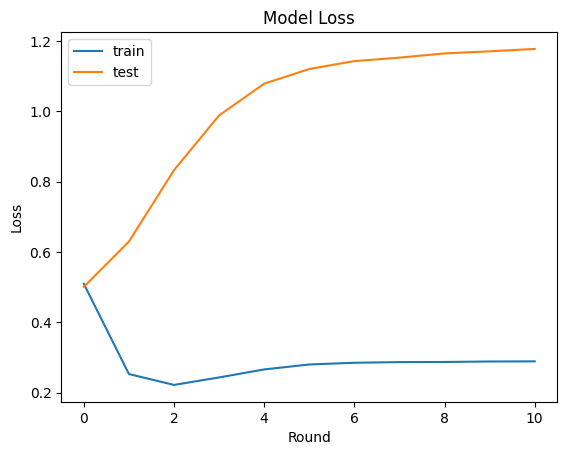

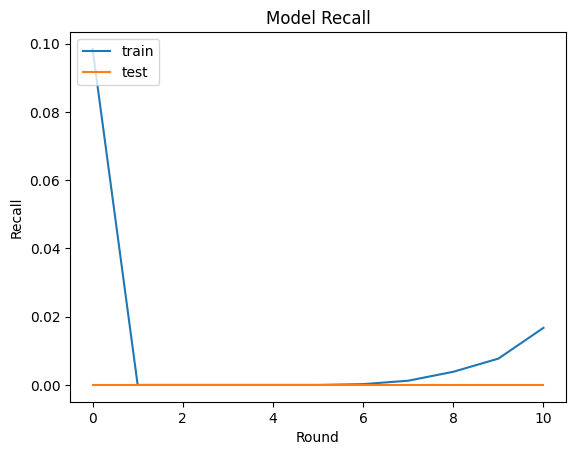

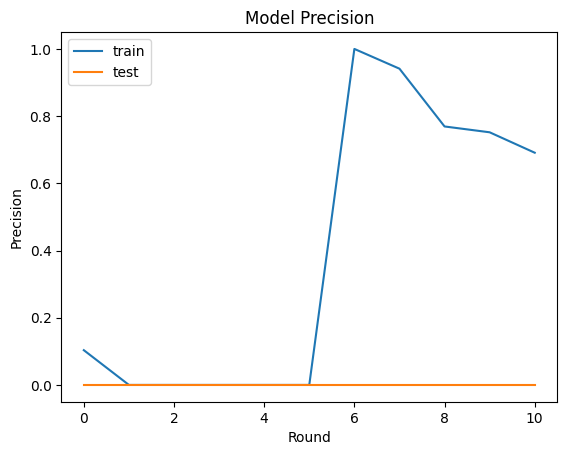

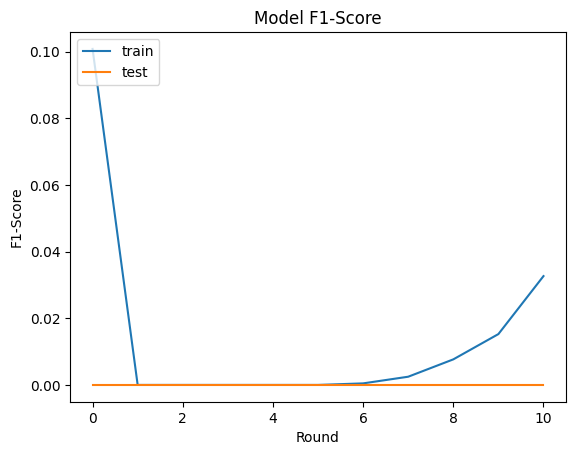

In [14]:
eval_results_df = eval_results_df.rename(columns={'loss': 'Loss', 'precision': 'Precision', 'recall': 'Recall'})
print(eval_results_df.columns)
#Plot accuracy of model
plt.plot(train_results_df['BinaryAccuracy'])
plt.plot(eval_results_df['binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(len(train_results_df['BinaryAccuracy'])))
plt.show()

#Plot loss of model
plt.plot(train_results_df['Loss'])
plt.plot(eval_results_df['Loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(len(train_results_df['Loss'])))
plt.show()

#Plot loss of model
plt.plot(train_results_df['Recall'])
plt.plot(eval_results_df['Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(len(train_results_df['Loss'])))
plt.show()

#Plot loss of model
plt.plot(train_results_df['Precision'])
plt.plot(eval_results_df['Precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(len(train_results_df['Loss'])))
plt.show()

#Plot loss of model
plt.plot(train_results_df['F1 Score'])
plt.plot(eval_results_df['F1 Score'])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
#plt.xticks(range(len(train_results_df['Loss'])))
plt.show()

In [15]:
print(train_results_df.tail(10))
print(eval_results_df.tail(10))

     Round  BinaryAccuracy      Loss  Precision    Recall  F1 Score
100  101.0        0.997739  0.012772   0.992121  0.985665  0.988882
101  102.0        0.997736  0.012994   0.992546  0.985202  0.988860
102  103.0        0.997702  0.012514   0.991529  0.985896  0.988704
103  104.0        0.997567  0.012821   0.991289  0.984806  0.988037
104  105.0        0.997759  0.012742   0.992548  0.985434  0.988978
105  106.0        0.998106  0.012381   0.993785  0.987614  0.990689
106  107.0        0.997075  0.013948   0.988992  0.982263  0.985616
107  108.0        0.996944  0.013266   0.988100  0.981866  0.984973
108  109.0        0.996846  0.013256   0.987569  0.981437  0.984493
109  110.0        0.998073  0.010149   0.992800  0.988274  0.990532
     Round  Precision    Recall  binary_accuracy  true_positives  \
100  101.0   1.000000  0.009651         0.796679            21.0   
101  102.0   1.000000  0.009651         0.796679            21.0   
102  103.0   1.000000  0.015165         0.797811